# Modèle pre-entrainer DENSE121 : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [1]:
# Chargement des modules necessaire :

import os

import random
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model

In [2]:
# On declare les chemins vers les donnees :

trainDir = 'Data/TRAIN'
validationDir = 'Data/TEST'
 
# On declare les dimensions pour les images (224,224) :
img_width, img_height = 224, 224

# On liste et stocke les chemins des images :
ImageTRAINCOVID = os.listdir(trainDir + '/COVID')
ImageTRAINNORMAL = os.listdir(trainDir + '/NORMAL')

ImageTESTCOVID = os.listdir(validationDir + '/COVID')
ImageTESTNORMAL = os.listdir(validationDir + '/NORMAL')

# On affiche le nombre d'image trouve :
print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.') 
print('Il y a ' + str(len(ImageTESTCOVID)) + ' images test de patient covid.') 
print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images test de patient non-covid.')

Il y a 460 images d'entrainement de patient covid.
Il y a 1266 images d'entrainement de patient non-covid.
Il y a 116 images test de patient covid.
Il y a 317 images test de patient non-covid.


TRAIN COVID


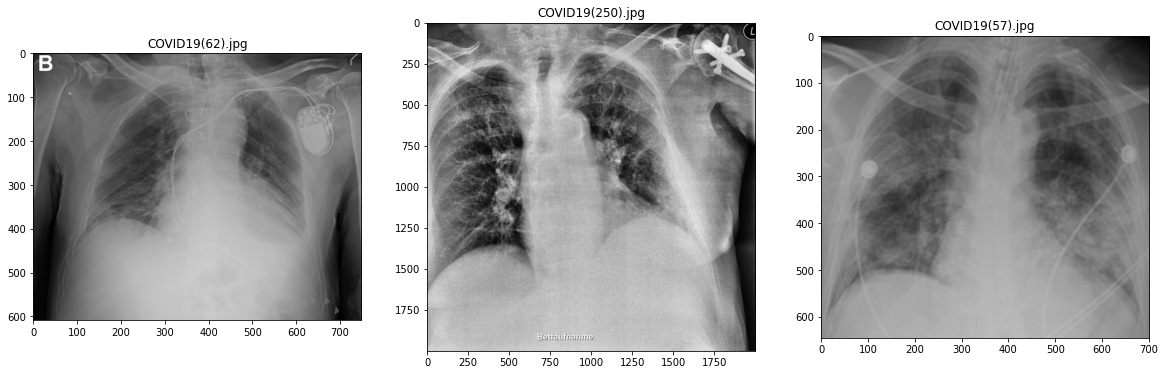

TEST COVID


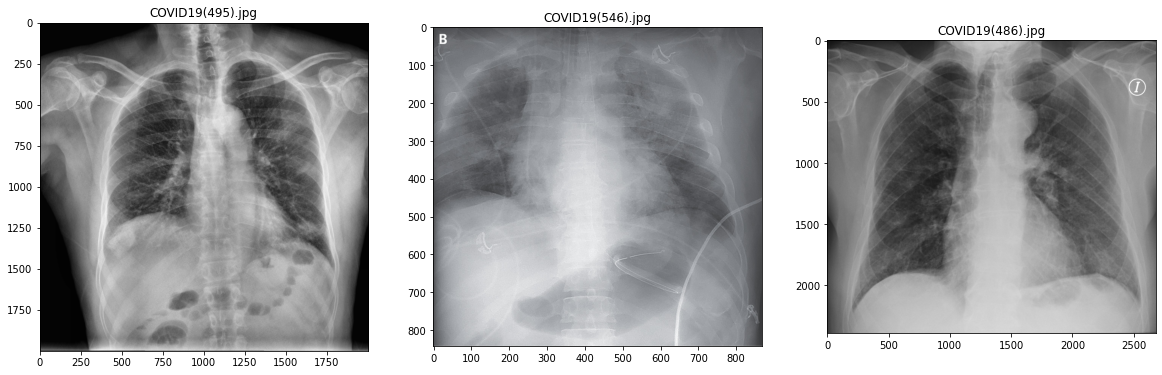

TRAIN NORMAL


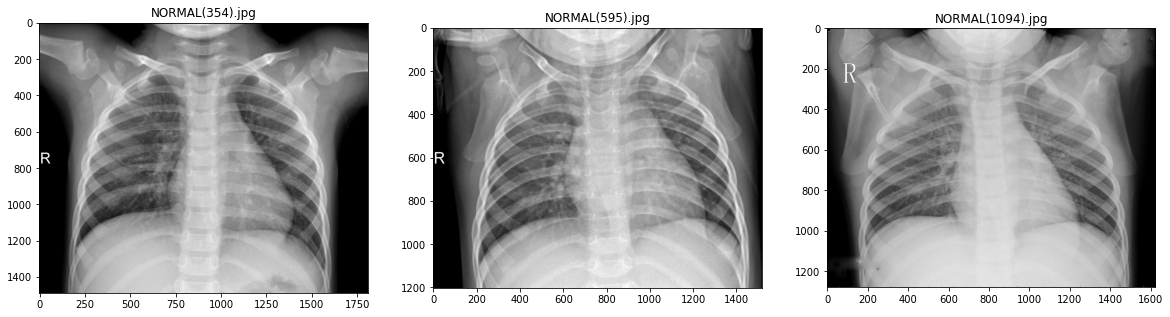

TEST NORMAL


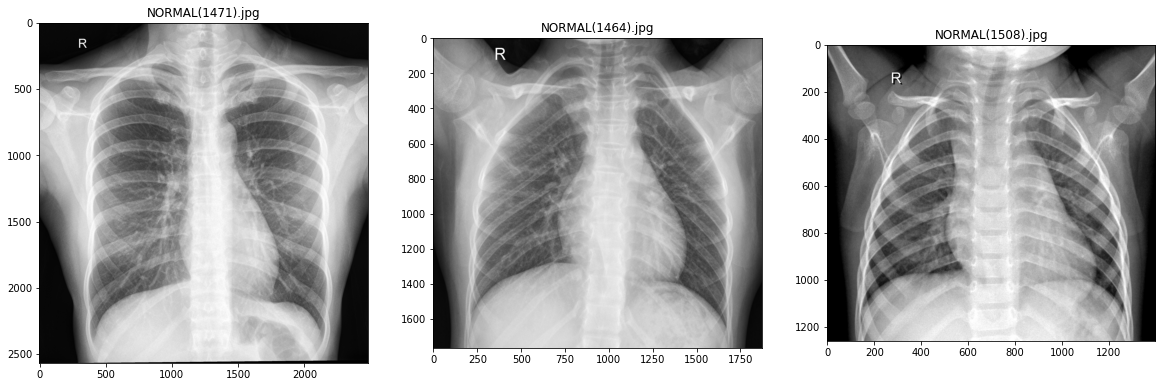

In [3]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(trainDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/COVID',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TEST COVID")
# COVID  :
plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTCOVID = random.choice(os.listdir(validationDir + '/COVID'))
    plt.imshow(plt.imread(os.path.join( validationDir +'/COVID',randomImageTESTCOVID)), cmap='gray')
    plt.title(randomImageTESTCOVID)
    
plt.show()

print("TRAIN NORMAL")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(trainDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join( trainDir +'/NORMAL',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


# TEST:

print("TEST NORMAL")

# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTESTNORMAL = random.choice(os.listdir(validationDir + '/NORMAL'))
    plt.imshow(plt.imread(os.path.join(validationDir +'/NORMAL',randomImageTESTNORMAL)), cmap='gray')
    plt.title(randomImageTESTNORMAL)
    
plt.show()

In [4]:
# Preprocessing :
# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :
train_generator = datagen.flow_from_directory(
        trainDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

validation_generator = datagen.flow_from_directory(
        validationDir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 1726 images belonging to 2 classes.
Found 433 images belonging to 2 classes.


In [5]:
# Chargement de DENSE121 sans la partie fully-connected avec le reseau convolutif :

model_dense = applications.DenseNet121(include_top=False, weights='imagenet')

In [ ]:
# On utilse le model VGG16 pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :
train_features = model_dense.predict_generator(train_generator, 1726 // batch_size)

validation_features = model_dense.predict_generator(validation_generator, 433 // batch_size)

# L'opération étant longue on enregistre les features obtenus :
np.save(open('models/trainFeatures_DENSE121_AllData.npy', 'wb'), train_features) # ecriture en binaire necessaire
np.save(open('models/validationFeatures_DENSE121_AllData.npy', 'wb'), validation_features) # Idem

In [6]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/trainFeatures_DENSE121_AllData.npy', 'rb'))
validation_features = np.load(open('models/validationFeatures_DENSE121_AllData.npy', 'rb'))

In [7]:
# On definit les labels :

train_labels = np.array([0] * 448 + [1] * 1248)

validation_labels = np.array([0] * 116 + [1] * 300)

# On peut maintenat tester plusieurs couches fully-connected à partir de ce modele :

In [8]:
# Premier modele : 
model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))


# On compile :
model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# On affiche :
model_top1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3211328   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,211,393
Trainable params: 3,211,393
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Second modele :
model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))

# On compile :
model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# On affiche :
model_top2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               6422656   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 6,422,785
Trainable params: 6,422,785
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Troisieme modele :
model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))

# On compile :
model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 12,845,569
Trainable params: 12,845,569
Non-trainable params: 0
_________________________________________________________________


In [11]:
# On definit les parametres pour l'entrainement :
epochs = 10


In [12]:
# On entraine le modèle 1 :

history1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 3s 53ms/step - loss: 3.4550 - accuracy: 0.8659 - val_loss: 0.0239 - val_accuracy: 0.9904
Epoch 2/10
53/53 [==============================] - 2s 39ms/step - loss: 0.1473 - accuracy: 0.9745 - val_loss: 0.2750 - val_accuracy: 0.9231
Epoch 3/10
53/53 [==============================] - 2s 39ms/step - loss: 0.2200 - accuracy: 0.9567 - val_loss: 0.0335 - val_accuracy: 0.9904
Epoch 4/10
53/53 [==============================] - 2s 46ms/step - loss: 0.1394 - accuracy: 0.9782 - val_loss: 0.0489 - val_accuracy: 0.9880
Epoch 5/10
53/53 [==============================] - 2s 40ms/step - loss: 0.1173 - accuracy: 0.9781 - val_loss: 0.3380 - val_accuracy: 0.9351
Epoch 6/10
53/53 [==============================] - 2s 41ms/step - loss: 0.1657 - accuracy: 0.9734 - val_loss: 0.0159 - val_accuracy: 0.9928
Epoch 7/10
53/53 [==============================] - 2s 40ms/step - loss: 0.1554 - accuracy: 0.9705 - val_loss: 0.0348 - val_accuracy: 0.9928
Epoch 8/10
53

In [13]:
# On entraine le modèle 2:

history2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 4s 71ms/step - loss: 5.5858 - accuracy: 0.8942 - val_loss: 0.3078 - val_accuracy: 0.9688
Epoch 2/10
53/53 [==============================] - 4s 68ms/step - loss: 0.4864 - accuracy: 0.9635 - val_loss: 0.0664 - val_accuracy: 0.9856
Epoch 3/10
53/53 [==============================] - 4s 68ms/step - loss: 0.3349 - accuracy: 0.9678 - val_loss: 0.0382 - val_accuracy: 0.9928
Epoch 4/10
53/53 [==============================] - 4s 68ms/step - loss: 0.1836 - accuracy: 0.9765 - val_loss: 0.1540 - val_accuracy: 0.9760
Epoch 5/10
53/53 [==============================] - 4s 68ms/step - loss: 0.1441 - accuracy: 0.9842 - val_loss: 0.5780 - val_accuracy: 0.9447
Epoch 6/10
53/53 [==============================] - 4s 71ms/step - loss: 0.0881 - accuracy: 0.9819 - val_loss: 0.0437 - val_accuracy: 0.9952
Epoch 7/10
53/53 [==============================] - 4s 68ms/step - loss: 0.1057 - accuracy: 0.9750 - val_loss: 0.0379 - val_accuracy: 0.9928
Epoch 8/10
53

In [14]:
# On entraine le modèle 3:

history3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/10
53/53 [==============================] - 7s 129ms/step - loss: 13.2815 - accuracy: 0.8202 - val_loss: 0.6463 - val_accuracy: 0.9639
Epoch 2/10
53/53 [==============================] - 7s 124ms/step - loss: 0.7738 - accuracy: 0.9753 - val_loss: 0.1083 - val_accuracy: 0.9904
Epoch 3/10
53/53 [==============================] - 7s 123ms/step - loss: 0.3140 - accuracy: 0.9605 - val_loss: 0.0383 - val_accuracy: 0.9928
Epoch 4/10
53/53 [==============================] - 6s 122ms/step - loss: 0.1594 - accuracy: 0.9750 - val_loss: 0.0334 - val_accuracy: 0.9904
Epoch 5/10
53/53 [==============================] - 6s 122ms/step - loss: 0.1772 - accuracy: 0.9791 - val_loss: 0.4206 - val_accuracy: 0.9399
Epoch 6/10
53/53 [==============================] - 7s 124ms/step - loss: 0.2652 - accuracy: 0.9687 - val_loss: 0.0321 - val_accuracy: 0.9928
Epoch 7/10
53/53 [==============================] - 7s 125ms/step - loss: 0.1137 - accuracy: 0.9755 - val_loss: 0.1779 - val_accuracy: 0.9712
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


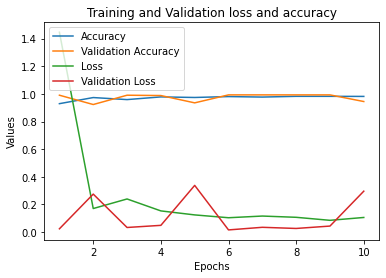

In [20]:
# Visualisation de l'entrainement : 


epochs = range(1,11)
plt.plot(epochs, history1.history['accuracy'], label='Accuracy')
plt.plot(epochs, history1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, history1.history['loss'], label='Loss')
plt.plot(epochs, history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


In [21]:
# On evalue :

# Avec les donnes de validation :

eval1 = model_top1.evaluate(validation_features, validation_labels,verbose=2)
eval2 = model_top2.evaluate(validation_features, validation_labels,verbose=2)
eval3 = model_top3.evaluate(validation_features, validation_labels,verbose=2)

# Avec les donnes de test :

# On prend quelques exemples aleatoires :

    # on visualise, on test , on affiche :

13/13 - 0s - loss: 0.2961 - accuracy: 0.9447
13/13 - 0s - loss: 0.0740 - accuracy: 0.9856
13/13 - 0s - loss: 0.0254 - accuracy: 0.9952


In [ ]:
# Data augmentation :


In [ ]:
# On reproduit le processus puis on compare :

In [22]:
# On enregistre le model (eventuel) :
model_top1.save_weights('models/dense121_lightTop_224_224_10G.h5')
model_top2.save_weights('models/dense121_mediumTop_224_224_10G.h5')
model_top3.save_weights('models/dense121_heavyTop_224_224_10G.h5')